In [ ]:
# Install required packages
# Instalación de paquetes necesarios

!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-image
!pip install opencv-python
!pip install sv-ttk


In [42]:
# Basic imports
import numpy as np
import pandas as pd

# Image processing imports
import matplotlib.pyplot as plt
from skimage import color, filters, measure, draw
from matplotlib.patches import Circle
import cv2
from skimage.io import imread

The goal is to detect, count and measure microdroplets like the ones from the image below.
_________________________________________________________________________________________________________
El objetivo es detectar, contar y medir microgotas como las de la imagen que se muestra a continuación.

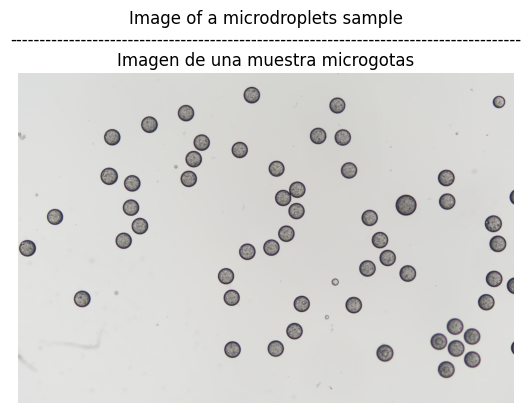

In [43]:

# Load the image
# Carga la imagen
image_path = 'images/1002.tif'
image = imread(image_path)

# Display the image
# Muestra la imagen
plt.imshow(image, cmap='gray')
plt.title('''Image of a microdroplets sample
---------------------------------------------------------------------------------------
Imagen de una muestra microgotas''')
plt.axis('off')
plt.show()

We load the image, transform it to grayscale and reduce its resolution to save computing time.
______________
Cargamos la imagen, la pasamos a escala de grises y reducimos su resolución para ahorrar tiempo de cómputo

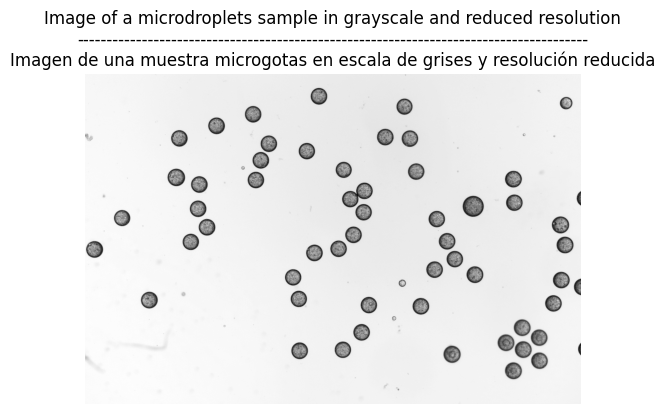

In [44]:

#we load the image, transform it to grayscale, and reduce its resolution to save computation time
#cargamos la imagen, la pasamos a escala de grises, reducimos su resolución para ahorrar tiempo de cómputo
SIZE_REDUCTION_RESOLUTION = 4
image = image[::SIZE_REDUCTION_RESOLUTION, ::SIZE_REDUCTION_RESOLUTION]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# show the image in grayscale and with reduced resolution
# mostrar la imagen en escala de grises y con la resolución reducida
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.title('''Image of a microdroplets sample in grayscale and reduced resolution
---------------------------------------------------------------------------------------
Imagen de una muestra microgotas en escala de grises y resolución reducida''')
plt.show()


These droplets are pretty round and easy to distinguish, so the well-tuned Hough transform for circle detection is enough.
________________________________________________
Estas gotas son muy redondas y fáciles de distinguir, por lo que la transformada de Hough para la detección de círculos bien ajustada es suficiente.

,x,y,radius
0,960,327,25
1,638,681,19
2,684,639,19
3,514,502,19
4,790,81,19


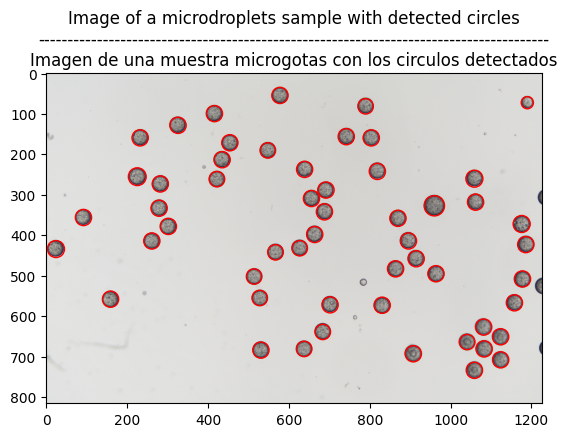

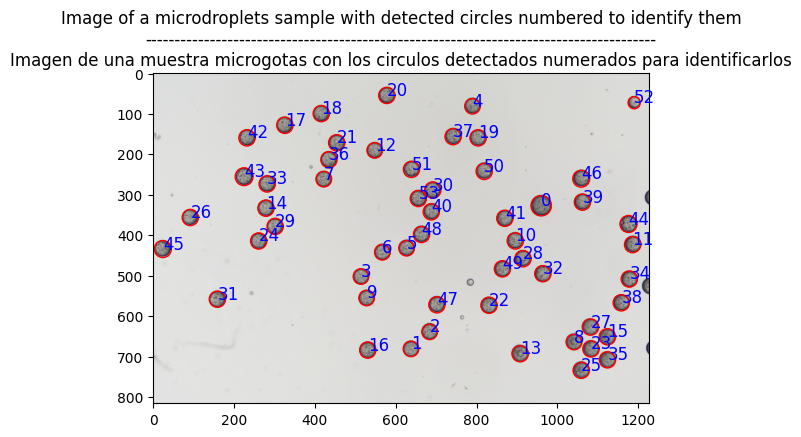

In [45]:

# apply the Hough transform to detect circles in the image
#aplicamos la transformada de hough para detectar los circulos en la imagen
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT_ALT, 1.5, minDist=10, param1=300, param2=0.9, minRadius=10, maxRadius=500)
# To understand the parameters of the HoughCircles function, you can check the OpenCV documentation: https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d
# Para entender los parámetros de la función HoughCircles, puedes consultar la documentación de OpenCV: https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d

# now that we have the circles, we want to get their coordinates and radii
#ahora que tenemos los circulos, queremos obtener sus coordenadas y radios
circles = np.round(circles[0, :]).astype("int")
cx, cy, radii = [], [], []

for (x, y, r) in circles:
    cx.append(x)
    cy.append(y)
    radii.append(r)

# draw the circles on the image
# y dibuja los circulos en la imagen
image_with_circles = image.copy()
fig, ax = plt.subplots()
ax.title.set_text('''Image of a microdroplets sample with detected circles
---------------------------------------------------------------------------------------
Imagen de una muestra microgotas con los circulos detectados''')
ax.imshow(image_with_circles)

i = 0
for center_y, center_x, radius in zip(cy, cx, radii):
    #print(f"Circle {i+1}: center: ({center_x}, {center_y}), radius: {radius*2*SIZE_REDUCTION_RESOLUTION}")
    i += 1
    circle = Circle((center_x, center_y), radius, fill=False, edgecolor='red')
    ax.add_patch(circle)

# we can also add numbers to each drop to identify them more easily
# podemos añadirle números a cada gota para identificarlas más fácilmente
fig, ax = plt.subplots()
ax.title.set_text('''Image of a microdroplets sample with detected circles numbered to identify them
---------------------------------------------------------------------------------------
Imagen de una muestra microgotas con los circulos detectados numerados para identificarlos''')
ax.imshow(image_with_circles)

i = 0
for center_y, center_x, radius in zip(cy, cx, radii):
    #print(f"Circle {i+1}: center: ({center_x}, {center_y}), radius: {radius*2*SIZE_REDUCTION_RESOLUTION}")
    ax.annotate(str(i), (center_x, center_y), color='blue', fontsize=12)
    i += 1
    circle = Circle((center_x, center_y), radius, fill=False, edgecolor='red')
    ax.add_patch(circle)

# show a dataframe with the results of the first 5 detected circles
#mostramos una tabla con los resultados de los 5 primeros circulos detectados
df = pd.DataFrame({'x': cx, 'y': cy, 'radius': radii})
display(df.head())


Now we have the dimensions in pixels, but we want them in micrometers. So we need to use a reference scale. In order to do that, in some of the images taken with the microscope I have added a scale that can be used as a reference.  
(The scale is in bright red so that it can be easily segmented from the rest of the image)
_______________________________________
Ahora bien tenemos las dimensiones en píxels, pero nosotros las queremos en micrometros. Por lo que necesitamos usar una escala de referencia. Para eso, en alguna de las imágenes tomadas a microscopio he añadido una escala que se puede usar de referencia.  
(El color rojo chillón de la escala es para poder segmentarla del resto de la imagen fácilmente)

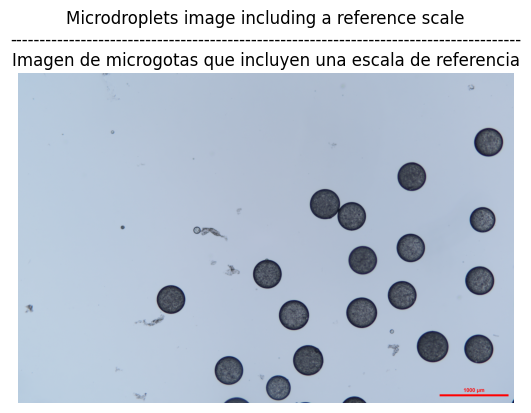

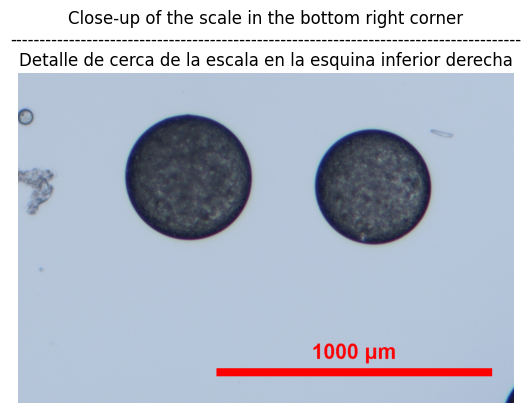

In [46]:


# Load the image
# Cargar la imagen
image_path = 'images/Escala 2x.tif'
image = imread(image_path)

# Display the image
# Mostrar la imagen
plt.imshow(image)
plt.title('''Microdroplets image including a reference scale
---------------------------------------------------------------------------------------
Imagen de microgotas que incluyen una escala de referencia''')
plt.axis('off')
plt.show()

# Obtener dimensiones de la imagen
# Get image dimensions
height, width = image.shape[:2]

# define the fraction of the image to show to 25% of the image
# Definir la fracción de la imagen a mostrar al 25% de la imagen
crop_fraction = 0.25 

# calculate coordinates for the crop
# Calcular coordenadas para el recorte
start_y = int(height * (1 - crop_fraction))
start_x = int(width * (1 - crop_fraction))

# Crop the bottom right corner
# Recortar la esquina inferior derecha
cropped_image = image[start_y:, start_x:]

# Show the cropped image
# Mostrar la imagen recortada
plt.imshow(cropped_image)
plt.title('''Close-up of the scale in the bottom right corner
---------------------------------------------------------------------------------------
Detalle de cerca de la escala en la esquina inferior derecha''')
plt.axis('off')
plt.show()


We will use the red color of the scale to segment it from the rest of the image
___
Aprovecharemos que la escala está en roja para separarla del resto de la imagen

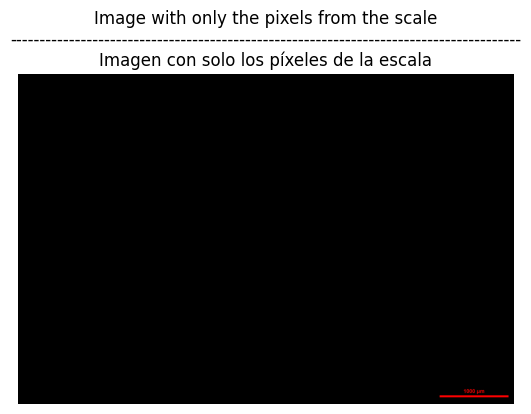

In [47]:
# Set to 0 all pixels that are not red
# Poner a 0 todos los píxeles que no sean rojos
red_pixels = image.copy()
red_pixels[(red_pixels[:, :, 0] < 200) | (red_pixels[:, :, 1] >= 100) | (red_pixels[:, :, 2] >= 100)] = 0

# Show the image with the pixels that are not red set to 0
# mostramos la imagen con los píxeles que no son rojos a 0
plt.imshow(red_pixels)
plt.title('''Image with only the pixels from the scale
---------------------------------------------------------------------------------------
Imagen con solo los píxeles de la escala''')
plt.axis('off')
plt.show()

Once we have the scale separated from the rest of the image we can move on to detect the contour of the scale
___
Una vez que tenemos la escala separada del resto de la imagen podemos pasar a detectar el contorno de la escala

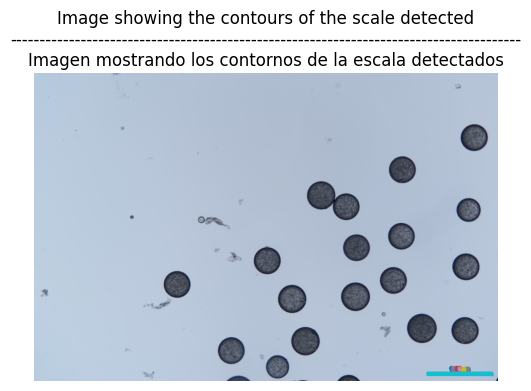

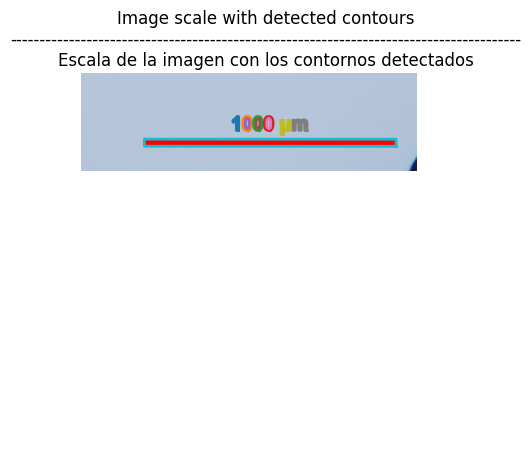

In [48]:

# First we convert the image to grayscale
# primero la pasamos a escala de grises
gray_image = color.rgb2gray(red_pixels)

# Apply Otsu to binarize the image into the background and the scale
# Aplicamos Otsu para binarizar la imagen en el fondo y la escala
thresh = filters.threshold_otsu(gray_image)
binary = gray_image > thresh

# Search for the contours of the scale using Marching squares algorithm
# Buscamos los contornos de la escala usando el algoritmo de Marching squares
contours = measure.find_contours(binary, level=0.8)


# Show the contours
# Mostramos los contornos
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
plt.imshow(image, cmap='gray')
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.axis('image')
plt.axis('off')
plt.title('''Image showing the contours of the scale detected
---------------------------------------------------------------------------------------
Imagen mostrando los contornos de la escala detectados''')
plt.show()

# plot contours
# trazar contornos
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.axis('image')
ax.set_axis_off()
plt.title('''Image scale with detected contours
---------------------------------------------------------------------------------------
Escala de la imagen con los contornos detectados''')

# Apply zoom to see better the scale with its contours
# Aplicamos zoom para ver mejor la escala con sus contornos
ax.set_xlim(4000, 5000)
ax.set_ylim(4000, 3000)
fig.canvas.draw()


As it can be seen, there is not just one contour, but several because apart from the scale, the distance is also written and each symbol is a new contour. The solution to this is to choose only the largest contour of all.
In order to do this, we will define rectangles that cover each contour and we will keep the one with the largest area.
___
Como se puede ver, no hay un solo contorno, si no que hay varios debido a que aparte de la escala, también está escrita la distancia y cada símbolo es un contorno nuevo. Esto tiene como solución escoger solo el contorno más grande de todos.
Para ello definiremos rectángulos que abarquen cada contorno y nos quedaremos con el que tenga un área mayor.

minr:  3116.8  minc:  4411.8  maxr:  3154.2  maxc:  4427.2
minr:  3116.8  minc:  4438.8  maxr:  3154.2  maxc:  4462.2
minr:  3116.8  minc:  4467.8  maxr:  3154.2  maxc:  4491.2
minr:  3116.8  minc:  4496.8  maxr:  3154.2  maxc:  4520.2
minr:  3122.2  minc:  4445.2  maxr:  3148.8  maxc:  4455.8
minr:  3122.2  minc:  4474.2  maxr:  3148.8  maxc:  4484.8
minr:  3122.2  minc:  4503.2  maxr:  3148.8  maxc:  4513.8
minr:  3125.8  minc:  4573.8  maxr:  3154.2  maxc:  4612.2
minr:  3126.8  minc:  4541.8  maxr:  3165.2  maxc:  4566.2
minr:  3177.8  minc:  4171.8  maxr:  3197.2  maxc:  4853.2


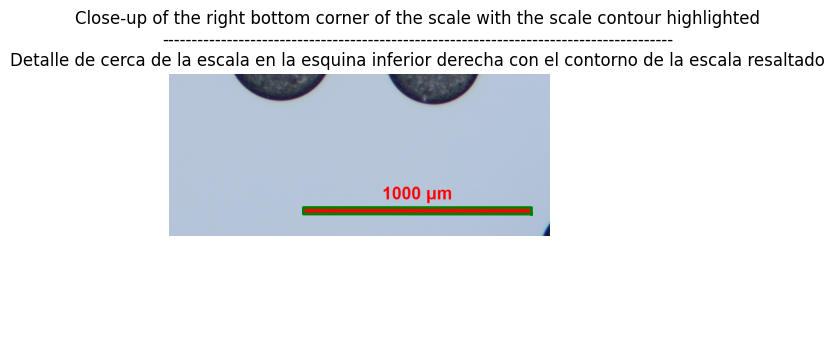

In [49]:

# Define a mask image and the variable that will contain the definitive contour
#definimos una máscara de imagen vacía y la variable que contendrá el contorno definitivo
mask = np.ones(image.shape, dtype="uint8")
definitive_contour = None

# Define a rectangle for each contour
#se define un rectangulo para cada contorno
for contour in contours:
    #minr, minc, maxr, maxc = measure.regionprops(contour.astype(int))[0].bbox
    minr = np.min(contour[:, 0])  # minimo valor de y
    minc = np.min(contour[:, 1])  # minimo valor de x
    maxr = np.max(contour[:, 0])  # maximo valor de y
    maxc = np.max(contour[:, 1])  # maximo valor de x
    print( "minr: ", minr, " minc: ", minc, " maxr: ", maxr, " maxc: ", maxc)
    # limit the minimum size of the contour to 1000 pixels to avoid small contours
    #limitamos el tamaño mínimo del contorno a 1000 píxeles para evitar contornos pequeños
    if (maxr - minr) * (maxc - minc) > 1000:
        # we keep the largest contour
        # nos quedamos con el contorno más grande
        if definitive_contour is None or (maxr - minr) * (maxc - minc) > (np.max(definitive_contour[:, 0]) - np.min(definitive_contour[:, 0])) * (np.max(definitive_contour[:, 1]) - np.min(definitive_contour[:, 1])):
            definitive_contour = contour

# Draw the definitive contour on the image
# Dibujamos el contorno definitivo en la imagen
if definitive_contour is not None:
    minr = np.min(definitive_contour[:, 0])  # minimo valor de y
    minc = np.min(definitive_contour[:, 1])  # minimo valor de x
    maxr = np.max(definitive_contour[:, 0])  # maximo valor de y
    maxc = np.max(definitive_contour[:, 1])  # maximo valor de x
    rr, cc = draw.rectangle_perimeter(start=(minr, minc), extent=(maxr-minr, maxc-minc), shape=image.shape)
    mask[rr, cc] = 0
    for r, c in zip(rr, cc):
        image[r, c] = [0, 255, 0]


# Show the definitive contour
# Mostramos la imagen
plt.imshow(image)

# Draw the contour (for example, in green to highlight it)
# Dibujamos el contorno (por ejemplo, en verde para destacarlo)
plt.plot(definitive_contour[:, 1], definitive_contour[:, 0], linewidth=2, color='green')

# Calculate the limits of the contour
# Calculamos los límites del contorno
x_min = np.min(definitive_contour[:, 1])
x_max = np.max(definitive_contour[:, 1])
y_min = np.min(definitive_contour[:, 0])
y_max = np.max(definitive_contour[:, 0])

# Define a margin so the zoom includes some space around the contour
# Definimos un margen para que el zoom incluya algo de espacio alrededor del contorno
margen = 400 

# Adjust the limits of the graph
# Ajustamos los límites de la gráfica
plt.xlim(x_min - margen, x_max + margen)
plt.ylim(y_max + margen, y_min - margen)

plt.axis('off')
plt.title('''Close-up of the right bottom corner of the scale with the scale contour highlighted
---------------------------------------------------------------------------------------
Detalle de cerca de la escala en la esquina inferior derecha con el contorno de la escala resaltado''')
plt.show()


From this contour we will take the width in pixels, and knowing that the scale is 1000 micrometers, we can now find out the proportion between the actual measurement and the pixels.
___
De este contorno tomaremos la anchura en píxeles, y sabiendo que la escala son 1000 micrómetros, ya podremos averiguar la proporción entre la medida real y los píxeles.

In [50]:
# Take the values of the x-axis
# Tomamos los valores del eje x     
minc = np.min(definitive_contour[:, 1])  # minimo valor de x
maxc = np.max(definitive_contour[:, 1])  # maximo valor de x

# Calculate the distance corresponding to each pixel
# calculamos la distancia que corresponde a cada píxel
distance = 1000
distance_pixels = maxc - minc
relation = distance/distance_pixels
print('Each pixel is', relation, ' micrometers')
print('Cada píxel es de', relation, ' micrómetros')

Each pixel is 1.4675667742882308  micrometers
Cada píxel es de 1.4675667742882308  micrómetros


And finally, all that remains is to apply this measure to the data we previously obtained from the droplet measurements.
___
Y finalmente solo nos queda aplicar esta medida a los datos que obtuvimos previamente de las medidas de las gotas.

In [51]:
# When applying the pixel size relationship to micrometers, it should be noted that the image when detecting the circles was reduced
#al aplicar la relación de tamaño de píxeles a micrómetros, hay que tener en cuenta que la imagen al detectar los círculos fue reducida
df_escala_real = pd.DataFrame({"x": df["x"], "y": df["y"], "diámetro (micrómetros)": df["radius"]*relation*SIZE_REDUCTION_RESOLUTION})
df_escala_real.head()

,x,y,diámetro (micrómetros)
0,960,327,146.756677
1,638,681,111.535075
2,684,639,111.535075
3,514,502,111.535075
4,790,81,111.535075


This method has proven to be significantly more accurate and faster for measuring these droplets compared to measuring them manually, with a difference between the automatic and human measurements of 2% of the diameter. Below is an example comparing a sample where the diameter measurement was performed manually compared to the measurement performed using this method.
___
Este método ha mostrado ser bastante más preciso y rápido para medir estas gotas en comparación con su medición de forma manual, con una diferencia entre la medición automática y la humana de un 2% del diámetro. A continuación se muestra una comparativa de ejemplo de una muestra en la que se realizó la medición del diámetro de forma manual comparada con la medición realizada con este método.

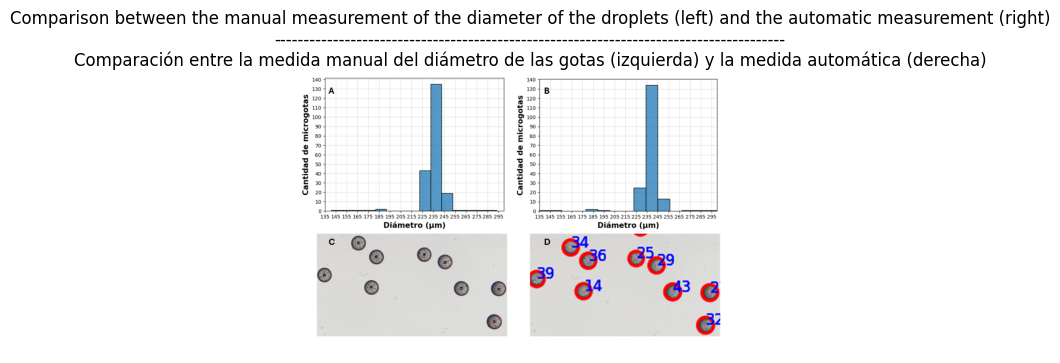

In [52]:
# Load the image
# Cargar la imagen
image_path = 'images/comparacion.png'
image = imread(image_path)

# Display the image
# Mostrar la imagen
plt.imshow(image)
plt.title('''Comparison between the manual measurement of the diameter of the droplets (left) and the automatic measurement (right)
---------------------------------------------------------------------------------------
Comparación entre la medida manual del diámetro de las gotas (izquierda) y la medida automática (derecha)''')
plt.axis('off')
plt.show()

It should be noted that this is an example with previously tested and adjusted parameters and with a type of particles and samples that are not too difficult to detect. For more complex image cases, in addition to adjusting the different parameters to the specific case, it may also require more complex image processing and subsequent statistical processing to remove false positives.
___
Hay que tener en cuenta que esto es un ejemplo con unos parámetros previamente probados y ajustados y con un tipo de partículas y unas muestras que no resultan demasiado difíciles de detectar, para casos de imágenes más complejas, además de ajustar los diferentes parámetros al caso concreto, también puede requerir de un tratamiento de imagen más complejo y de realizar un tratamiento estadístico posterior para eliminar los falsos positivos.

Furthermore, when performing this processing with a large number of images, it is necessary to create a more complex program, where, in addition to applying a reduction in the resolution of the images, a parallelization of the detection process is carried out in order to avoid excessively high computation times. In addition, a graphical interface can be useful to carry out the tests and adjustments in a more comfortable way.
This is available in the notebook that includes the complete program and not in this notebook, since the objective of this is only to explain the part related to image processing.
(Parallelization only works in the .py to avoid increasing the complexity of the code, as jupyter notebook has problems carrying out the parallelization)
___
Además, al realizar este procesamiento con una gran cantidad de imágenes, es necesario realizar un programa más complejo, donde, además de aplicar una reducción de la resolución de las imágenes se lleve a cabo una paralelización del proceso de detección para no tener tiempos de cómputo excesivamente altos, además una interfaz gráfica puede ser útil para realizar las pruebas y los ajustes de forma más cómoda.
Esto se encuentra disponible en el notebook que incluye el programa completo y no en este notebook, ya que el objetivo de este solamente es explicar la parte relativa al procesamiento de imagen.
(La paralelización solo funciona en el .py para evitar aumentar la complejidad del código, ya que jupyter notebook da problemas para llevar a cabo la paralelización)